In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.signal as scys
import enum
from datetime import datetime
import os
from tensorflow.python.client import device_lib
from keras.models import Model
from keras import layers, losses
print(device_lib.list_local_devices())
from numpy import genfromtxt


# dash0, dash1, dash2, 
# nodash0, ...

#dash0




sample_size = 5000
step_size = 8

from datetime import datetime
from packaging import version
import tensorboard
%load_ext tensorboard


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3995524439267010503
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5968805888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18126288215201943838
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:0c:00.0, compute capability: 7.5"
]


In [2]:
def unr_data_slim(path):
        count_errors = 0
        
        data = np.genfromtxt(path, delimiter =",")
        Daten = np.empty((1, len(data)))
        I_OUT = data
        I_OUT = I_OUT.astype(np.float32)
        
        Daten[0] = I_OUT[:,2]
        
#         for j in range(0, len(data[2])):
#             if(Daten[2][j] < 0 or Daten[2][j] > 10000):
#                 count_errors+=1
#                 Daten[2][j] = Daten[2][j-1]
#         print("Errors: ", count_errors)
        return Daten


def add_label(data, label):
    help = np.ones((len(data),data.shape[1]+1))*label
    help[:,0:data.shape[1]] = data
    return help
        
def force_reshape(data, shape):
    diff = shape - (len(data) % shape)
    for i in range(0, diff):
        data = np.append(data, data[-1])
    return np.reshape(data, (-1, shape))

    
def force_reshape_grad(data, shape, step_size):
    n = len(data)
    p = shape
    
    max_comb = int(np.floor((n-p+step_size)/step_size))
    new_data = np.ones((max_comb, shape))
    x = 0
    for i in range(0, len(data)-p, step_size):
        new_data[x] = data[i:i+p]
        x+=1
  
    return new_data

In [3]:
def load_training_slim(path):
    Hz_5_Data = None
    for idx, filename in enumerate(os.listdir(path)):
        if(idx == 0):
            Data = unr_data_slim(path+filename)
            Hz_5_Data = Data
        else:
            Data = unr_data_slim(path+filename)
            Hz_5_Data = np.concatenate((Hz_5_Data, Data), axis =1)
    return Hz_5_Data

def trans_data(data, label):
    print(data.shape)
    current = data[0, :]
    plt.plot(current)
    current = force_reshape_grad(current, sample_size, step_size)
    current = add_label(current, label)
    return current


def autoload_data_slim(dir):
    sets = os.listdir(dir)
    print(sets)
    num_sets = len(sets)
    data = []
    for i in range(num_sets):
        data.append(load_training_slim(dir+sets[i]+"\\"))
       
    return data

def autolable_data(data):
    num_sets = len(data)
    print(num_sets)
    for i in range(num_sets):
        data[i]  = trans_data(data[i], i)

    return data
    


In [4]:
       
                                                  
model = keras.Sequential(
    [
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sample_size,1)),
        layers.MaxPooling1D(pool_size=4),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sample_size,1)),
        layers.MaxPooling1D(pool_size=4),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sample_size,1)),
        layers.MaxPooling1D(pool_size=4),
        #was 32
        layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=4),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation = "relu", name = "hidden4"),
        layers.Dense(50, activation = "relu", name = "hidden6"),
        layers.Dense(2, activation ="softmax", name = "Output"),
    ]
)
model.compile(optimizer = "adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4998, 32)          128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1249, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1247, 32)          3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 311, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 309, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 77, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 75, 32)            3

['dash', 'no_dash']
[[         nan 124.09999847  84.5        ... 117.09999847 118.40000153
           nan]]
2
(1, 621324)
(1, 585485)


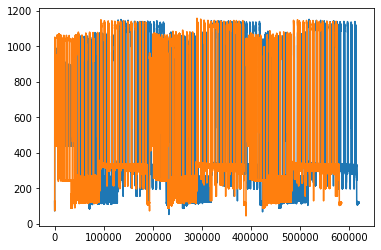

In [5]:
base_dir = "Printer3D//"
test_gramm = autoload_data_slim(base_dir)
print(test_gramm[0])
data = autolable_data(test_gramm)
del test_gramm

In [8]:
Training_Data = np.concatenate((data[0], data[1]), axis =0) 
del data
np.random.shuffle(Training_Data)
Solution = Training_Data[:, Training_Data.shape[1]-1]
Training_Data =Training_Data[:,:-1]
max1 = Training_Data.max()
min1 = Training_Data.min()
print("Max:", max1, min1)

Training_Data = (Training_Data - min1) / (max1-min1)
#Training_Data = inject(Training_Data, 50)
TDD = np.zeros((Training_Data.shape[0],Training_Data.shape[1],1))
TDD[:,:,0] = Training_Data

del Training_Data

#history =model.fit(TDD, Solution, epochs = 6, validation_split = 0.1)







Max: 1157.5999755859375 43.20000076293945


In [12]:
print(TDD.shape)
print(Solution.shape)

(149600, 5000, 1)
(149600,)


In [9]:
history =model.fit(TDD, Solution, epochs = 5, validation_split = 0.1)


Epoch 1/5
4208/4208 [==============================] - 33s 6ms/step - loss: 0.6498 - accuracy: 0.5862 - val_loss: 0.5948 - val_accuracy: 0.6698
Epoch 2/5
4208/4208 [==============================] - 25s 6ms/step - loss: 0.3423 - accuracy: 0.8309 - val_loss: 0.2410 - val_accuracy: 0.8928
Epoch 3/5
4208/4208 [==============================] - 24s 6ms/step - loss: 0.1473 - accuracy: 0.9367 - val_loss: 0.0983 - val_accuracy: 0.9558
Epoch 4/5
4208/4208 [==============================] - 25s 6ms/step - loss: 0.0958 - accuracy: 0.9597 - val_loss: 0.1115 - val_accuracy: 0.9556
Epoch 5/5
4208/4208 [==============================] - 25s 6ms/step - loss: 0.0744 - accuracy: 0.9691 - val_loss: 0.0649 - val_accuracy: 0.9737


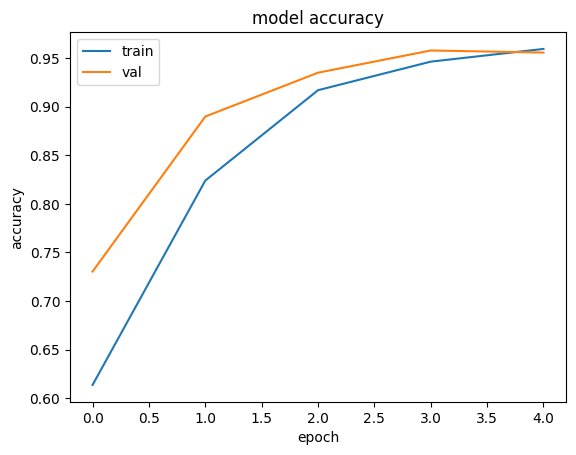

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Model_Acc_3Conv_6Epochs")
plt.show()

In [9]:
mod_dir = "C:\\Users\\student\\Downloads\\Work\\Data\\ML_MODELS\\NUC_CLSY_BIG_4"
model.save(mod_dir)
# Convert the model
#converter = tf.lite.TFLiteConverter.from_saved_model(mod_dir) # path to the SavedModel directory
#tflite_model = converter.convert()

# Save the model.
#with open('PEN_1200_BOX_V1.tflite', 'wb') as f:
 # f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\student\Downloads\Work\Data\ML_MODELS\NUC_CLSY_BIG_4\assets


In [10]:
import tensorboard
%load_ext tensorboard
import datetime

latent_dim = 50
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(sample_size,1)),
        layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
        layers.Flatten(),
        layers.Dense(latent_dim)
        ])
        
        
        
        
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(units=(sample_size-2*3+2)*16, activation="relu"),
            layers.Reshape(target_shape=(sample_size-2*3+2,16)),
            layers.Conv1DTranspose(filters=8, kernel_size=3, activation='relu'),
            layers.Conv1DTranspose(filters=16, kernel_size=3, activation='relu'),

        ])


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(TDD, TDD, epochs=5, batch_size = 16, shuffle=True, callbacks=[tensorboard_callback])
autoencoder.summary()



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
mod_dir = "C:\\Users\\student\\Downloads\\Work\\Data\\ML_MODELS\\NUC_ANOM_4_BIG"
autoencoder.save(mod_dir)

In [ ]:
base_dir_leg = "C:\\Users\\student\\Downloads\\Work\\Data\\TR_BOX_LEGACY\\"
test_gramm_leg = autoload_data_slim(base_dir_leg)
data_leg = autolable_data(test_gramm_leg)
del test_gramm_leg


Training_Data_leg = np.concatenate((data_leg[0], data_leg[1]), axis =0) 
del data_leg

np.random.shuffle(Training_Data_leg)

Training_Data_leg =Training_Data_leg[:,:-1]

Training_Data_leg = (Training_Data_leg - min1) / (max1-min1)
#Training_Data = inject(Training_Data, 50)
TDD_leg = np.zeros((Training_Data_leg.shape[0],Training_Data_leg.shape[1],1))
TDD_leg[:,:,0] = Training_Data_leg

del Training_Data_leg

#history =model.fit(TDD, Solution, epochs = 6, validation_split = 0.1)



In [ ]:
#mod_dir = "C:\\Users\\student\\Downloads\\Work\\Data\\ML_MODELS\\ANOMALY_FULL_0to3"
#autoencoder = tf.keras.models.load_model(mod_dir)
plt.plot(history.history['loss'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train'], loc='upper left')
#plt.savefig("Model_Acc_3Conv_6Epochs")
plt.show()
known = []
unknown = []

samples = 5000

a = TDD_leg[0:samples]
b = autoencoder.predict(TDD_leg[0:samples])

#untrained sample
x = np.sum(tf.keras.losses.MSE(a,b), axis = 1)

#trained samples
y = np.sum(tf.keras.losses.MSE(TEST_TDD[0:samples], autoencoder.predict(TEST_TDD[0:samples])), axis = 1)




In [ ]:
limits = [0.01,0.02,0.03,0.04,0.05,0.075,0.10,0.125,0.13,0.14,0.145,0.15,0.155,0.16,0.175]

for el in limits:
    anom_known = 0
    anom_unknown = 0



    for i in range(0,samples):
        if(x[i] > el):
            anom_unknown +=1
        if(y[i] > el):
            anom_known +=1
    unkn = anom_unknown/len(x)
    kn = anom_known/len(y)

    print( el, kn, unkn, unkn - kn)
        
    
    
plt.plot(x, "o", color = "b", label = "Data not trained on")
plt.plot(y, "v", color = "r", alpha = 0.4, label = "Data trained on")
plt.axhline(y=0.14, color='w', linestyle='-')
plt.legend(loc = 1)
plt.xlabel("Sample")
plt.ylabel("MSE")
plt.ylim(0, 0.5)
plt.show
plt.savefig("AUTOENCD.png")